In [15]:
import os
import numpy as np
import random
import pickle
import copy
from matplotlib import pyplot as plt
from datetime import datetime
from sklearn.model_selection import KFold

#from sklearn.decomposition import PCA
#from scipy.optimize import minimize
#from scipy.optimize import line_search

np.random.seed(0)
random.seed(0)

> All the copy and pasted imports since Jupyter doesnt treat the environment as a package...

In [2]:
class ModelBase:
    def __init__(self, ID, w, opt_method, smoothbatch_lr=1, alphaF=0.0, alphaE=1e-6, alphaD=1e-4, verbose=False, starting_update=9, PCA_comps=64, current_round=0, num_clients=14, log_init=0):
        # Not input
        self.num_updates = 19
        self.starting_update=starting_update
        self.update_ix = [0,  1200,  2402,  3604,  4806,  6008,  7210,  8412,  9614, 10816, 12018, 13220, 14422, 15624, 16826, 18028, 19230, 20432, 20769]
        self.id2color = {0:'lightcoral', 1:'maroon', 2:'chocolate', 3:'darkorange', 4:'gold', 5:'olive', 6:'olivedrab', 
                7:'lawngreen', 8:'aquamarine', 9:'deepskyblue', 10:'steelblue', 11:'violet', 12:'darkorchid', 13:'deeppink'}
        
        self.type = 'BaseClass'
        self.ID = ID
        self.PCA_comps = PCA_comps
        self.pca_channel_default = 64  # When PCA_comps equals this, DONT DO PCA
        if w.shape!=(2, self.PCA_comps):
            #print(f"Class BaseModel: Overwrote the provided init decoder: {w.shape} --> {(2, self.PCA_comps)}")
            self.w = np.random.rand(2, self.PCA_comps)
        else:
            self.w = w
        self.w_prev = copy.deepcopy(self.w)
        self.dec_log = [copy.deepcopy(self.w)]
        self.w_prev = copy.deepcopy(self.w)
        self.num_clients = num_clients
        self.log_init = log_init

        self.alphaF = alphaF
        self.alphaE = alphaE
        self.alphaD = alphaD

        self.local_train_error_log = []
        self.global_train_error_log = []
        self.local_test_error_log = []
        self.global_test_error_log = []
        
        self.opt_method = opt_method.upper()
        self.current_round = current_round
        self.verbose = verbose
        self.smoothbatch_lr = smoothbatch_lr

    def __repr__(self): 
        return f"{self.type}{self.ID}"
    
    def display_info(self): 
        return f"{self.type} model: {self.ID}\nCurrent Round: {self.current_round}\nOptimization Method: {self.opt_method}"
    

In [58]:
class Client(ModelBase):
    def __init__(self, ID, w, opt_method, full_client_dataset, data_stream, smoothbatch_lr=0.75, current_round=0, PCA_comps=64, 
                availability=1, final_usable_update_ix=17, global_method='FedAvg', max_iter=1, normalize_EMG=True, starting_update=9, 
                track_cost_components=True, log_decs=True, val_set=False,
                tol=1e-10, lr=1, beta=0.01, track_gradient=True,  
                num_steps=1, use_zvel=False, current_fold=0, scenario="", 
                mix_in_each_steps=False, mix_mixed_SB=False, delay_scaling=0, random_delays=False, download_delay=1, 
                upload_delay=1, validate_memory_IDs=True, local_round_threshold=25, condition_number=3, 
                verbose=False, test_split_type='kfoldcv', num_kfolds=5, test_split_frac=0.3):
        super().__init__(ID, w, opt_method, smoothbatch_lr=smoothbatch_lr, current_round=current_round, PCA_comps=PCA_comps, 
                         verbose=verbose, num_clients=14, log_init=0)
        '''
        Note self.smoothbatch gets overwritten according to the condition number!  
        If you want NO smoothbatch then set it to 0
        '''

        assert(full_client_dataset['training'].shape[1]==64) # --> Shape is (20770, 64)
        # Don't use anything past update 17 since they are different (update 17 is the short one, only like 300 datapoints)
        self.current_update = starting_update
        self.current_train_update = 0
        self.starting_update = starting_update
        self.final_usable_update_ix = final_usable_update_ix
        self.local_dataset = full_client_dataset['training'][self.update_ix[starting_update]:self.update_ix[final_usable_update_ix], :]
        self.local_labelset = full_client_dataset['labels'][self.update_ix[starting_update]:self.update_ix[final_usable_update_ix], :]

        self.global_method = global_method.upper()
        self.validate_memory_IDs = validate_memory_IDs
        # NOT INPUT
        self.type = 'Client'
        self.chosen_status = 0
        self.latest_global_round = 0
        self.normalize_EMG = normalize_EMG

        # Sentinel Values
        self.F = None
        self.V = None
        self.F2 = None
        self.V2 = None
        self.learning_batch = None

        self.dt = 1.0/60.0
        self.lr = lr  # Learning rate
        self.beta = beta # PFA 2nd step learning rate (not used as of now...)
        # Round minimization output to the nearest int or keep as a float?  Don't need arbitrary precision
        self.round2int = False
        self.max_iter = max_iter
        
        # Maneeshika Code:
        self.use_zvel = use_zvel
        self.hit_bound = 0  # This is just initializing it to 0 (eg no hits yet)
        
        # FL CLASS STUFF
        # Availability for training
        self.availability = availability
        # Toggle streaming aspect of data collection: {Ignore updates and use all the data; 
        #  Stream each update, moving to the next update after local_round_threshold iters have been run; 
        #  After 1 iteration, move to the next update}
        self.data_stream = data_stream  # {'full_data', 'streaming', 'advance_each_iter'} 
        # Number of gradient steps to take when training (eg amount of local computation):
        self.num_steps = num_steps  # This is Tau in PFA!
        # UPDATE STUFF
        self.local_round_threshold = local_round_threshold

        # PRACTICAL / REAL WORLD
        # Not using the delay stuff right now
        # Boolean setting whether or not up/download delays should be random or predefined
        self.random_delays = random_delays
        # Scaling from random [0,1] to number of seconds
        self.delay_scaling = delay_scaling
        # Set the delay times
        if self.random_delays: 
            self.download_delay = random.random()*self.delay_scaling
            self.upload_delay = random.random()*self.delay_scaling
        else:
            self.download_delay = download_delay
            self.upload_delay = upload_delay
        
        # ML Parameters / Conditions
        #cond_dict = {1:(0.25, 1e-3, 1), 2:(0.25, 1e-4, 1), 3:(0.75, 1e-3, 1), 4:(0.75, 1e-4, 1), 5:(0.25, 1e-4, -1), 6:(0.25, 1e-4, -1), 7:(0.75, 1e-3, -1), 8:(0.75, 1e-4, -1)}
        #cond_smoothbatch, self.alphaD, self.init_dec_sign = cond_dict[condition_number]
        if type(smoothbatch_lr)==str and smoothbatch_lr.upper()=='OFF':
            self.smoothbatch_lr = 0  # AKA Use only the new dec, no mixing
        #elif smoothbatch_lr==-1:  
        #    # Let the condition number set smoothbatch
        #    self.smoothbatch_lr = cond_smoothbatch
        else:
            # Set smoothbatch to whatever you manually entered
            self.smoothbatch_lr=smoothbatch_lr
        # LOGS
        self.log_decs = log_decs
        # Overwrite the logs since global and local track in slightly different ways
        self.track_cost_components = track_cost_components
        self.performance_log = []
        self.Dnorm_log = []
        self.Fnorm_log = []
        self.track_gradient = track_gradient
        self.local_gradient_log = []
        self.update_transition_log = []

        ## Not used AFAIK... --> control where SmoothBatch is used (verify this code still exists if you plan on using)
        self.mix_in_each_steps = mix_in_each_steps
        self.mix_mixed_SB = mix_mixed_SB

        self.global_w = copy.deepcopy(self.w)

        # TRAIN TEST DATA SPLIT
        self.test_split_type = test_split_type.upper() # "KFOLDCV" "UPDATE16" "ENDFRACTION"
        self.test_split_frac = test_split_frac
        self.num_kfolds = num_kfolds
        self.val_set = val_set
        self.scenario = scenario.upper()
        self.current_fold = current_fold
        self.test_update_ix = None
        self.train_update_ix = None

        if self.test_split_type=="KFOLDCV":
            if self.scenario=="INTRA":
                # Include these in the init? ...
                append_leftovers_to_last_fold = False
                shift_leftovers_across_folds = True

                # Filter update_ix to only include updates 9-16
                valid_updates = [ix for ix in self.update_ix if starting_update <= self.update_ix.index(ix) < final_usable_update_ix]
                # THIS SETS THE TESTING FOLD
                if append_leftovers_to_last_fold:
                    '''Leftover updates are appended to the last fold. Updates are continuous but the last fold will be much bigger...'''
                    # Calculate the number of updates per fold
                    updates_per_fold = len(valid_updates) // self.num_kfolds
                    #print(f"updates_per_fold: {updates_per_fold}")
                    # Ensure we have enough updates for the specified number of folds
                    assert updates_per_fold > 0, "Not enough valid updates for the specified number of folds"
                    # Create folds --> THESE ARE THE TEST UPDATES!
                    self.folds = [valid_updates[i:i+updates_per_fold] for i in range(0, len(valid_updates), updates_per_fold)]
                    # If there are leftover updates, add them to the last fold
                    while len(self.folds) > self.num_kfolds:
                        if self.ID==0:
                            print(f"len(self.folds) {len(self.folds)} > self.num_kfolds {self.num_kfolds} --> Thus, popping and adding one to the last fold!")
                        self.folds[-2].extend(self.folds[-1])
                        self.folds.pop()
                    assert len(self.folds) == self.num_kfolds, f"Expected {self.num_kfolds} folds, got {len(self.folds)}"
                elif shift_leftovers_across_folds:
                    '''Purpose of this code is to shift/push updates to earlier folds, to maintain contintuity, while making test folds more even in size'''
                    # TODO: This has not been validated at all...
                    # Calculate the total number of updates and the ideal number of updates per fold
                    total_updates = len(valid_updates)
                    ideal_updates_per_fold = total_updates / self.num_kfolds
                    self.folds = []
                    start_idx = 0
                    for fold in range(self.num_kfolds):
                        end_idx = int(round((fold + 1) * ideal_updates_per_fold))
                        self.folds.append(valid_updates[start_idx:end_idx])
                        start_idx = end_idx
                    # Ensure all updates are included
                    if start_idx < total_updates:
                        self.folds[-1].extend(valid_updates[start_idx:])
                    if hasattr(self, 'ID') and self.ID == 0:
                        print(f"Created {len(self.folds)} folds:")
                        for i, fold in enumerate(self.folds):
                            print(f"Fold {i}: {len(fold)} updates: {[self.update_ix.index(i) for i in fold]}")
                    assert len(self.folds) == self.num_kfolds, f"Expected {self.num_kfolds} folds, got {len(self.folds)}"
                    assert sum(len(fold) for fold in self.folds) == total_updates, "Not all updates were included in the folds"
                # SET THE TEST DATA
                # Get the current fold's update indices
                fold_updates = self.folds[self.current_fold]
                self.test_update_ix = [self.update_ix.index(ele) for ele in fold_updates]
                self.train_update_ix = [ele for ele in self.update_ix if ((self.update_ix.index(ele)>=self.starting_update) and (self.update_ix.index(ele) not in self.test_update_ix) and (self.update_ix.index(ele)<self.final_usable_update_ix))]

                # Find the start and end indices for the TEST dataset
                ## THE BELOW CODE ASSUMES TEST UPDATES IN FOLD ARE CONTIGUOUS
                ## The values in fold_updates represent the START of each update, NOT the BOUNDS!!  Thus the adjustment
                lower_bound_pre_idx = self.update_ix.index(fold_updates[0])
                upper_bound_pre_idx = self.update_ix.index(fold_updates[-1]) + 1  # +1 to include the last update (eg otherwise this update num would be the upperbound, as opposed to included)
                # Upper and lower bounds mapped to the new size (since we do not use anything before starting_update...)
                lower_bound = self.update_ix[lower_bound_pre_idx] - self.update_ix[starting_update]
                upper_bound = self.update_ix[upper_bound_pre_idx] - self.update_ix[starting_update]
                # Set testing data
                self.testing_data = self.local_dataset[lower_bound:upper_bound, :]
                self.testing_labels = self.local_labelset[lower_bound:upper_bound, :]

                # SIMULATE THE FIRST DATA STREAM FOR THE STARTING UPDATE
                ## Eg, set self.V, self.s, etc etc
                # self.train_update_ix starts at starting_update already!
                lower_bound = self.train_update_ix[0] - self.update_ix[self.starting_update]
                upper_bound = lower_bound + 1200
            elif self.scenario=="CROSS":
                self.test_split_idx = -1
                # Setting the testing set to the whole dataset so that it can be extracted
                ## If this is a training cliet this will be overwritten by other client's testing dataset
                ## I guess I could set this to 
                upper_bound = self.local_dataset.shape[0]
                lower_bound = 0
                self.testing_data = self.local_dataset
                self.testing_labels = self.local_labelset

            if "PFA" in self.global_method:
                mid_point = (lower_bound+upper_bound)//2
                self.learning_batch = mid_point - lower_bound

                s_temp = self.local_dataset[lower_bound:mid_point, :]
                s_temp2 = self.local_dataset[mid_point:upper_bound, :]
                p_ref_lim = self.local_labelset[lower_bound:mid_point, :]
                p_ref_lim2 = self.local_labelset[mid_point:upper_bound, :]
                self.p_reference = np.transpose(p_ref_lim)
                self.p_reference2 = np.transpose(p_ref_lim2)

                # First, normalize the entire s matrix
                if self.normalize_EMG:
                    s_normed2 = s_temp2/np.amax(s_temp2)
                else:
                    s_normed2 = s_temp2
                # Now do PCA unless it is set to 64 (AKA the default num channels i.e. no reduction)
                # Also probably ought to find a global transform if possible so I don't recompute it every time...
                if self.PCA_comps!=self.pca_channel_default:  
                    pca = PCA(n_components=self.PCA_comps)
                    s_normed2 = pca.fit_transform(s_normed2)
                self.s2 = np.transpose(s_normed2)
                self.F2 = self.s2[:,:-1] # note: truncate F for estimate_decoder
                v_actual2 = self.w@self.s2
                p_actual2 = np.cumsum(v_actual2, axis=1)*self.dt  # Numerical integration of v_actual to get p_actual
                self.V2 = (self.p_reference2 - p_actual2)*self.dt
            else:
                self.learning_batch = upper_bound - lower_bound
                s_temp = self.local_dataset[lower_bound:upper_bound, :]
                # For Maneeshika's code:
                p_ref_lim = self.local_labelset[lower_bound:upper_bound, :]
                # This is the used label
                self.p_reference = np.transpose(p_ref_lim)

            # First, normalize the entire s matrix
            if self.normalize_EMG:
                s_normed = s_temp/np.amax(s_temp)
            else:
                s_normed = s_temp
            # Now do PCA unless it is set to 64 (AKA the default num channels i.e. no reduction)
            # Also probably ought to find a global transform if possible so I don't recompute it every time...
            if self.PCA_comps!=self.pca_channel_default:  
                pca = PCA(n_components=self.PCA_comps)
                s_normed = pca.fit_transform(s_normed)
            self.s = np.transpose(s_normed)
            self.F = self.s[:,:-1] # note: truncate F for estimate_decoder
            v_actual = self.w@self.s
            p_actual = np.cumsum(v_actual, axis=1)*self.dt  # Numerical integration of v_actual to get p_actual
            self.V = (self.p_reference - p_actual)*self.dt
        elif self.test_split_type=="UPDATE16":
            # self.update_ix[17] and further is the short update, self.update_ix[18] is literally the last value
            # This is technically update 17 but it doesnt matter, update 17 is the last usable update (17/19)
            lower_bound = self.update_ix[16]
            #//2  #Use only the second half of each update
            upper_bound = self.update_ix[17]
            self.test_split_idx = lower_bound
            self.testing_data = self.local_dataset[self.test_split_idx:upper_bound, :]
            self.testing_labels = self.local_labelset[self.test_split_idx:upper_bound, :]
            # TODO: There ought to be some assert here to make sure that self.testing_XYZ doesnt have a shape of zero...
        elif self.test_split_type=="ENDFRACTION":
            test_split_product_index = self.local_dataset.shape[0]*self.test_split_frac
            # Convert this value to the closest update_ix value
            train_test_update_number_split = min(self.update_ix, key=lambda x:abs(x-test_split_product_index))
            self.test_split_idx = self.update_ix.index(train_test_update_number_split)
            if self.test_split_idx<17:
                print(f"self.test_split_idx is {self.test_split_idx}, so subtracting 1")
                self.test_split_idx -= 1
            assert(self.test_split_idx > self.starting_update)
            lower_bound = self.test_split_idx
            upper_bound = self.local_dataset.shape[0]
            self.testing_data = self.local_dataset[self.test_split_idx:, :]
            self.testing_labels = self.local_labelset[self.test_split_idx:, :]
        else:
            raise ValueError("test_split_type not working as expected")
        
        if self.scenario=="INTRA":
            # If so, then DONT overwrite the training data and labels!
            pass
        elif self.scenario=="CROSS":
            self.training_data = self.local_dataset[:self.test_split_idx, :]
            self.training_labels = self.local_labelset[:self.test_split_idx, :]
            self.test_learning_batch = upper_bound - lower_bound
        s_temp = self.testing_data
        if self.normalize_EMG:
            s_normed = s_temp/np.amax(s_temp)
        else:
            s_normed = s_temp
        if self.PCA_comps!=self.pca_channel_default:  
            pca = PCA(n_components=self.PCA_comps)
            s_normed = pca.fit_transform(s_normed)
        self.s_test = np.transpose(s_normed)
        self.F_test = self.s_test[:,:-1] # note: truncate F for estimate_decoder
        self.p_test_reference = np.transpose(self.testing_labels)
        
            
    # 0: Main Loop
    def execute_training_loop(self):
        self.simulate_data_stream()
        self.train_model()
        
        # LOG EVERYTHING
        ## I guess this is actually after train_model is called...
        # TODO: Revamp this to be self.local_dec_log ...
        self.dec_log.append(self.w)
        # TODO: Not sure why this would have higher error than global, given that global is right below...
        self.local_train_error_log.append(self.eval_model(which='local'))
        if self.global_method!="NOFL":
            # TODO: Still doesn't tell me what that global would be better than local...
            self.global_train_error_log.append(self.eval_model(which='global'))
        # Log Cost Comp
        if self.track_cost_components:
            self.performance_log.append(self.alphaE*(np.linalg.norm((self.w@self.F - self.V[:,1:]))**2))
            self.Dnorm_log.append(self.alphaD*(np.linalg.norm(self.w)**2))  # This is the scaled norm...
            self.Fnorm_log.append(np.linalg.norm(self.F)**2)  # This is FNorm, not the F in the cost func (which is 0 because of self.alphaF)


    def set_testset(self, test_dataset_obj):
        lower_bound = 0

        if type(test_dataset_obj) is type([]):
            running_num_test_samples = 0
            self.s_test = []
            self.F_test = []
            self.p_test_reference = []
            for test_dset in test_dataset_obj:
                self.testing_data = test_dset[0]
                self.testing_labels = test_dset[1]

                # TODO: Verify that shape index is correct
                running_num_test_samples += self.testing_data.shape[0]

                s_temp = self.testing_data
                if self.normalize_EMG:
                    s_normed = s_temp/np.amax(s_temp)
                else:
                    s_normed = s_temp
                if self.PCA_comps!=self.pca_channel_default:  
                    pca = PCA(n_components=self.PCA_comps)
                    s_normed = pca.fit_transform(s_normed)
                self.s_test.append(np.transpose(s_normed))
                self.F_test.append(np.transpose(s_normed)[:,:-1]) # note: truncate F for estimate_decoder
                self.p_test_reference.append(np.transpose(self.testing_labels))

            upper_bound = running_num_test_samples
            # TODO: This might be incorrect... it is calculated differently than the below branch...
            ## Eg maybe this should be a list of each upper-lower? Not sure...
            ## Probably doesn't matter? Not even sure if this is used
            self.test_learning_batch = upper_bound - lower_bound
        else:
            self.testing_data = test_dataset_obj[0]
            self.testing_labels = test_dataset_obj[1]
            # TODO: Verify that shape index is correct
            upper_bound = self.testing_data.shape[0]

            self.test_learning_batch = upper_bound - lower_bound

            s_temp = self.testing_data
            if self.normalize_EMG:
                s_normed = s_temp/np.amax(s_temp)
            else:
                s_normed = s_temp
            if self.PCA_comps!=self.pca_channel_default:  
                pca = PCA(n_components=self.PCA_comps)
                s_normed = pca.fit_transform(s_normed)
            self.s_test = np.transpose(s_normed)
            self.F_test = self.s_test[:,:-1] # note: truncate F for estimate_decoder
            self.p_test_reference = np.transpose(self.testing_labels)
    
    
    def get_testing_dataset(self):
        return self.testing_data, self.testing_labels
            
            
    def simulate_data_stream(self):
        streaming_method = self.data_stream
        need_to_advance=True
        # TODO: Idk if I want the current_round increment here......
        ## This is sort of fine since it's just the round and doesn't matter that much 
        self.current_round += 1

        if (self.current_update>=self.final_usable_update_ix-1) or (self.train_update_ix is not None and self.current_train_update>=(len(self.train_update_ix)-1)):  #17: previously 17 but the last update is super short so I cut it out
            self.logger = "UNNAMED"
            #print("Maxxed out your update (you are on update 18), continuing training on last update only")
            # Probably ought to track that we maxed out --> LOG SYSTEM
            # We are stopping an update early, so use -3/-2 and not -2/-1 (the last update)
            # TODO: This is sus with INTRA, although I doubt it reaches it ever
            if self.scenario=="INTRA":
                # Should this be -2/-1 or -1/? ...?
                lower_bound = self.train_update_ix[-2]
                upper_bound = self.train_update_ix[-1]
            else:
                lower_bound = self.update_ix[16] - self.update_ix[self.starting_update]
                upper_bound = self.update_ix[17] - self.update_ix[self.starting_update]
            self.learning_batch = upper_bound - lower_bound
            need_to_advance=False
        elif streaming_method=='full_data':
            self.logger = "full_data"
            lower_bound = self.update_ix[0]  # Starts at 0 and not update 10, for now
            upper_bound = self.update_ix[-1]
            self.learning_batch = upper_bound - lower_bound
            # TODO: need_to_advance shouldn't ever run, once lower_bound and upper_bound have been set once
            need_to_advance=False
        elif streaming_method=='streaming':
            self.logger = "streaming"
            if self.scenario=="INTRA":
                # Really ought to move this branch back so that the other streaming methods are included too...
                ## Since this version uses the folds to set the streaming index
                ## Eg the existing lower_bounds and upper_bounds would be incorrect (might be incorrect for other versions even wtihout kfcv...)
                ### NAH ignore the old versions. We only doing KFCV now

                # If we pass threshold, move on to the next update
                ## > 2 since starts at 0 but is immediately incremented to 1 in this func (should not update immediately)
                if (self.current_round>2) and (self.current_round%self.local_round_threshold==0):
                    self.current_update += 1
                    self.current_train_update += 1
                    self.update_transition_log.append(self.latest_global_round)
                    if self.verbose==True and self.ID==0:
                        # self.current_update here should really be changed...
                        print(f"Client{self.ID}: New update after lrt passed: (new update, current global round, current local round): {self.current_update, self.latest_global_round, self.current_round}")
                        print()
                    need_to_advance = True
                #elif self.current_round>2:  # This is the base case
                #    need_to_advance = False
                else:  # This is for the init case (current round is 0 or 1)
                    # This should be False actually, I don't need it to advance immediately...
                    need_to_advance = False
            elif self.scenario=="CROSS":
                # If we pass threshold, move on to the next update
                if self.current_round>2 and self.current_round%self.local_round_threshold==0:
                    self.current_update += 1
                    self.update_transition_log.append(self.latest_global_round)
                    if self.verbose==True and self.ID==0:
                        print(f"Client {self.ID}: New update after lrt passed: (new update, current global round, current local round): {self.current_update, self.latest_global_round, self.current_round}")
                        print()
                        
                    need_to_advance = True
                else:
                    # This is for the init case (current round is 0 or 1)
                    # need_to_advance is true, so we overwrite s and such... this is fine 
                    ## Uhh changed it so now this is the default case (removed current_round>2 branch), not sure if this is correct...

                    need_to_advance = False
        elif streaming_method=='advance_each_iter':
            #lower_bound = (self.update_ix[self.current_update] + self.update_ix[self.current_update+1])//2 
            lower_bound = (self.update_ix[self.current_update]) - self.update_ix[self.starting_update]
            upper_bound = self.update_ix[self.current_update+1] - self.update_ix[self.starting_update]
            self.learning_batch = upper_bound - lower_bound
            self.current_update += 1
            self.current_train_update += 1
        else:
            raise ValueError(f'streaming_method ("{streaming_method}") not recognized: this data streaming functionality is not supported')
            
        if need_to_advance:
            if self.scenario=="INTRA":
                # Should the 0 be changed to self.current_update... would need to be subtracted by starting_update...
                lower_bound = self.train_update_ix[self.current_train_update] - self.update_ix[self.starting_update]
                # This might be a subpar soln... pretty hardcoded in but it doesnt really matter for this dataset I dont think
                upper_bound = lower_bound + 1200

                if "PFA" in self.global_method:
                    mid_point = (lower_bound+upper_bound)//2
                    self.learning_batch = mid_point - lower_bound

                    s_temp = self.local_dataset[lower_bound:mid_point, :]
                    s_temp2 = self.local_dataset[mid_point:upper_bound, :]
                    p_ref_lim = self.local_labelset[lower_bound:mid_point, :]
                    p_ref_lim2 = self.local_labelset[mid_point:upper_bound, :]
                    self.p_reference = np.transpose(p_ref_lim)
                    self.p_reference2 = np.transpose(p_ref_lim2)

                    # First, normalize the entire s matrix
                    if self.normalize_EMG:
                        s_normed2 = s_temp2/np.amax(s_temp2)
                    else:
                        s_normed2 = s_temp2
                    # Now do PCA unless it is set to 64 (AKA the default num channels i.e. no reduction)
                    # Also probably ought to find a global transform if possible so I don't recompute it every time...
                    if self.PCA_comps!=self.pca_channel_default:  
                        pca = PCA(n_components=self.PCA_comps)
                        s_normed2 = pca.fit_transform(s_normed2)
                    self.s2 = np.transpose(s_normed2)
                    self.F2 = self.s2[:,:-1] # note: truncate F for estimate_decoder
                    v_actual2 = self.w@self.s2
                    p_actual2 = np.cumsum(v_actual2, axis=1)*self.dt  # Numerical integration of v_actual to get p_actual
                    self.V2 = (self.p_reference2 - p_actual2)*self.dt
                else:
                    self.learning_batch = upper_bound - lower_bound
                    s_temp = self.local_dataset[lower_bound:upper_bound, :]
                    #print(f"Client{self.ID} TRAINING DATA UPDATE: Mean, var, and norm: {np.mean(s_temp), np.var(s_temp), np.linalg.norm(s_temp)}")
                    # For Maneeshika's code:
                    #p_ref_lim = np.vstack([self.training_labels[self.update_ix.index(update):self.update_ix.index(update)+1, :] 
                    #               for update in train_updates])
                    p_ref_lim = self.local_labelset[lower_bound:upper_bound, :]
                    # This is the used label
                    self.p_reference = np.transpose(p_ref_lim)
            elif self.scenario=="CROSS":
                #lower_bound = (self.update_ix[self.current_update] + self.update_ix[self.current_update+1])//2
                lower_bound = (self.update_ix[self.current_update]) - self.update_ix[self.starting_update]
                upper_bound = self.update_ix[self.current_update+1] - self.update_ix[self.starting_update]
                self.learning_batch = upper_bound - lower_bound

                if "PFA" in self.global_method:
                    mid_point = (lower_bound+upper_bound)//2
                    s_temp = self.training_data[lower_bound:mid_point,:]
                    s_temp2 = self.training_data[mid_point:upper_bound,:]
                    self.p_reference = np.transpose(self.training_labels[lower_bound:mid_point,:])
                    self.p_reference2 = np.transpose(self.training_labels[mid_point:upper_bound,:])
                    # For Maneeshika's code, otherwise not used:
                    p_ref_lim = self.training_labels[lower_bound:mid_point,:]
                    p_ref_lim2 = self.training_labels[mid_point:upper_bound,:]
                else:  # FEDAVG AND NOFL!
                    s_temp = self.training_data[lower_bound:upper_bound,:]
                    self.p_reference = np.transpose(self.training_labels[lower_bound:upper_bound,:])
                    # For Maneeshika's code, otherwise not used:
                    p_ref_lim = self.training_labels[lower_bound:upper_bound,:]
                
            # First, normalize the entire s matrix
            if self.normalize_EMG:
                s_normed = s_temp/np.amax(s_temp)
            else:
                s_normed = s_temp
            # Now do PCA unless it is set to 64 (AKA the default num channels i.e. no reduction)
            # Also probably ought to find a global transform if possible so I don't recompute it every time...
            if self.PCA_comps!=self.pca_channel_default:  
                pca = PCA(n_components=self.PCA_comps)
                s_normed = pca.fit_transform(s_normed)
            self.s = np.transpose(s_normed)
            #print(f"Client{self.ID} TRAINING DATA UPDATE: Mean, var, and norm: {np.mean(self.s), np.var(self.s), np.linalg.norm(self.s)}")
            self.F = self.s[:,:-1] # note: truncate F for estimate_decoder
            v_actual = self.w@self.s
            p_actual = np.cumsum(v_actual, axis=1)*self.dt  # Numerical integration of v_actual to get p_actual
            if "PFA" in self.global_method:
                if self.normalize_EMG:
                    s_normed2 = s_temp2/np.amax(s_temp2)
                else:
                    s_normed2 = s_temp2
                if self.PCA_comps!=self.pca_channel_default:  
                    pca = PCA(n_components=self.PCA_comps)
                    s_normed2 = pca.fit_transform(s_normed2)
                self.s2 = np.transpose(s_normed2)
                self.F2 = self.s2[:,:-1] # note: truncate F for estimate_decoder
                v_actual2 = self.w@self.s2
                p_actual2 = np.cumsum(v_actual2, axis=1)*self.dt  # Numerical integration of v_actual to get p_actual
                
            #####################################################################
            # Add the boundary conditions code here
            if self.use_zvel:
                # Maneeshika code
                if self.current_round<2:
                    self.vel_est = np.zeros_like((p_ref_lim))
                    self.pos_est = np.zeros_like((p_ref_lim))
                    self.int_vel_est = np.zeros_like((p_ref_lim))
                    self.vel_est[0] = self.w@self.s[:,0]  # Translated from: Ds_fixed@emg_tr[0]
                    self.pos_est[0] = [0, 0]
                else:
                    prev_vel_est = self.vel_est[-1]
                    prev_pos_est = self.pos_est[-1]
                    
                    self.vel_est = np.zeros_like((p_ref_lim))
                    self.pos_est = np.zeros_like((p_ref_lim))
                    self.int_vel_est = np.zeros_like((p_ref_lim))
                    
                    self.vel_est[0] = prev_vel_est
                    self.pos_est[0] = prev_pos_est
                for tt in range(1, self.s.shape[1]):
                    # Note this does not keep track of actual updates, only the range of 1 to s.shape[1] (1202ish)
                    vel_plus = self.w@self.s[:,tt]  # Translated from: Ds_fixed@emg_tr[tt]
                    p_plus = self.pos_est[tt-1, :] + (self.vel_est[tt-1, :]*self.dt)
                    # These are just correctives, such that vel_plus can get bounded
                    # x-coordinate
                    if abs(p_plus[0]) > 36:  # 36 hardcoded from earlier works
                        p_plus[0] = self.pos_est[tt-1, 0]
                        vel_plus[0] = 0
                        self.hit_bound += 1 # update hit_bound counter
                    if abs(p_plus[1]) > 24:  # 24 hardcoded from earlier works
                        p_plus[1] = self.pos_est[tt-1, 1]
                        vel_plus[1] = 0
                        self.hit_bound += 1 # update hit_bound counter
                    if self.hit_bound > 200:  # 200 hardcoded from earlier works
                        p_plus[0] = 0
                        vel_plus[0] = 0
                        p_plus[1] = 0
                        vel_plus[1] = 0
                        self.hit_bound = 0
                    # now update velocity and position
                    self.vel_est[tt] = vel_plus
                    self.pos_est[tt] = p_plus
                    # calculate intended velocity
                    self.int_vel_est[tt] = calculate_intended_vels(p_ref_lim[tt], p_plus, 1/self.dt)

                # self.V must be set ONLY WITHIN TRAINING
                self.V = np.transpose(self.int_vel_est[:tt+1])
                #print(f"V.shape: {self.V.shape}")
            else:
                # Original code
                # self.V must be set ONLY WITHIN TRAINING
                self.V = (self.p_reference - p_actual)*self.dt
                if "PFA" in self.global_method:
                    self.V2 = (self.p_reference2 - p_actual2)*self.dt

        
    def eval_model(self, which):
        if which=='local':
            my_dec = self.w
            my_V = self.V
        elif which=='global':
            my_dec = self.global_w
            my_V = self.V
        elif which=='pers' and "PFA" in self.global_method:
            my_dec = self.w
            my_V = self.V
        else:
            raise ValueError("Please set <which> to either local or global")
        # Just did this so we wouldn't have the 14 decimals points it always tries to give
        if self.round2int:
            temp = np.ceil(cost_l2(self.F, my_dec, my_V, alphaE=self.alphaE, alphaD=self.alphaD, Ne=self.PCA_comps))
            # Setting to int is just to catch overflow errors
            # For RT considerations, ints are also generally ints cheaper than floats...
            out = int(temp)
        else:
            temp = cost_l2(self.F, my_dec, my_V, alphaE=self.alphaE, alphaD=self.alphaD, Ne=self.PCA_comps)
            out = round(temp, 7)
        return out
        

    def test_metrics(self, model, which, return_cost_func_comps=False):
        ''' No training, just evaluates the given model on the client's testing dataset (which may be the multi-client CROSS testset, if that has been set externally already) '''
        # NOTE: Hit bound code may be incompatible with this!
        
        if which=='local':
            test_log = self.local_test_error_log
        elif which=='global':
            test_log = self.global_test_error_log
        else:
            raise ValueError('test_metrics which does not exist. Must be local, global, or pers')
            
        if type(self.F_test) is type([]):
            #print("LIST VERSION IS RUNNING")
            ## This is the version that runs by default

            running_test_loss = 0
            running_num_samples = 0
            if return_cost_func_comps:
                running_vel_error = 0
                running_dec_error = 0
            for i in range(len(self.F_test)):
                # TODO: Ensure that this is supposed to be D@s and not D@F...
                # Not totally sure why this iterates... why doesn't it just operate on the entire matrix? Idk

                batch_samples = self.F_test[i].shape[0]

                v_actual = model@self.s_test[i]
                p_actual = np.cumsum(v_actual, axis=1)*self.dt  # Numerical integration of v_actual to get p_actual
                V_test = (self.p_test_reference[i] - p_actual)*self.dt

                if return_cost_func_comps:
                    batch_loss, vel_error, dec_error = cost_l2(self.F_test[i], model, V_test, alphaE=self.alphaE, alphaD=self.alphaD, Ne=self.PCA_comps, return_cost_func_comps=return_cost_func_comps)
                    running_vel_error += vel_error * batch_samples
                    running_dec_error += dec_error * batch_samples
                else:
                    batch_loss = cost_l2(self.F_test[i], model, V_test, alphaE=self.alphaE, alphaD=self.alphaD, Ne=self.PCA_comps, return_cost_func_comps=return_cost_func_comps)
                running_test_loss += batch_loss * batch_samples  # Accumulate weighted loss by number of samples in batch
                running_num_samples += batch_samples
            normalized_test_loss = running_test_loss / running_num_samples  # Normalize by total number of samples
            if return_cost_func_comps:
                normalized_vel_error = running_vel_error / running_num_samples
                normalized_dec_error = running_dec_error / running_num_samples
            test_log.append(normalized_test_loss)
        else:
            #print("MATRIX(?) VERSION IS RUNNING")
            ## THIS RUNS FOR INTRA!

            total_samples = self.F_test.shape[1]
            
            # Don't need to multiply and then divide by total samples since it is a constant
            ## Eg we would multiply by that var and then just divide it out, since this is 1 iteration on the full matrix

            # TODO: Ensure that this is supposed to be D@s and not D@F...
            v_actual = model@self.s_test
            p_actual = np.cumsum(v_actual, axis=1)*self.dt  # Numerical integration of v_actual to get p_actual
            V_test = (self.p_test_reference - p_actual)*self.dt

            if return_cost_func_comps:
                test_loss, vel_error, dec_error = cost_l2(self.F_test, model, V_test, alphaE=self.alphaE, alphaD=self.alphaD, Ne=self.PCA_comps, return_cost_func_comps=return_cost_func_comps)
            else:
                test_loss = cost_l2(self.F_test, model, V_test, alphaE=self.alphaE, alphaD=self.alphaD, Ne=self.PCA_comps, return_cost_func_comps=return_cost_func_comps)

            # ... wtf is this doing... aligning shape?
            assert(total_samples!=self.PCA_comps)

            # SHOULD THESE BE NORMALIZED???
            ## They are never multipled by total_samples to begin with.......
            normalized_test_loss = test_loss / total_samples  # Normalize by the number of samples
            if return_cost_func_comps:
                normalized_vel_error = vel_error / total_samples
                normalized_dec_error = dec_error / total_samples
            test_log.append(normalized_test_loss)
        
        # This was returning V_test for some reason
        ## I have None as a placeholder for now, maybe I'll return testing samples? But it already has access to that...
        ## Probably should just remove, just have to remove it everywhere in the code...
        if return_cost_func_comps:
            return normalized_test_loss, normalized_vel_error, normalized_dec_error
        else:
            return normalized_test_loss, None


In [54]:
path = r'C:\Users\kdmen\Desktop\Research\Data\CPHS_EMG'
model_saving_dir = r"C:\Users\kdmen\Desktop\Research\personalization-privacy-risk\PythonVersion\PythonSimsRevamp\models"
cond0_filename = r'\cond0_dict_list.p'
all_decs_init_filename = r'\all_decs_init.p'
nofl_decs_filename = r'\nofl_decs.p'
id2color = {0:'lightcoral', 1:'maroon', 2:'chocolate', 3:'darkorange', 4:'gold', 5:'olive', 6:'olivedrab', 
            7:'lawngreen', 8:'aquamarine', 9:'deepskyblue', 10:'steelblue', 11:'violet', 12:'darkorchid', 13:'deeppink'}
implemented_client_training_methods = ['GD', 'FullScipyMin', 'MaxIterScipyMin']
NUM_USERS = 14
# For exclusion when plotting later on
#bad_nodes = [] #[1,3,13]
D_0 = np.random.rand(2,64)
num_updates = 18
step_indices = list(range(num_updates))

MAX_ITER=None  # For MAXITERSCIPYMIN. Use FULLSCIPYMIN for complete minimization, otherwise stay with 1

COLORS_LST = ['red', 'blue', 'magenta', 'orange', 'darkviolet', 'lime']
ALPHA = 0.7

# get current date and time
CURRENT_DATETIME = str(datetime.now().strftime("%m-%d_%H-%M"))

STARTING_UPDATE=10
DATA_STREAM='streaming'
NUM_KFOLDS=5
USE_HITBOUNDS = False
PLOT_EACH_FOLD = False
USE_KFOLDCV = True
TEST_SPLIT_TYPE = 'KFOLDCV'

with open(path+cond0_filename, 'rb') as fp:
    cond0_training_and_labels_lst = pickle.load(fp)

In [5]:
def gradient_cost_l2(F, D, V, alphaD=1e-4, alphaE=1e-6, 
                     Nd=2, Ne=64, flatten=True):
    D = np.reshape(D,(Nd, Ne))
    Vplus = V[:,1:]
    if flatten:
        return (2*(D@F - Vplus)@F.T*(alphaE) + 2*alphaD*D ).flatten()
    else:
        return 2*(D@F - Vplus)@F.T*(alphaE) + 2*alphaD*D 

def cost_l2(F, D, V, alphaD=1e-4, alphaE=1e-6, Nd=2, Ne=64, return_cost_func_comps=False):
    D = np.reshape(D,(Nd,Ne))
    Vplus = V[:,1:]
    # Performance
    term1 = alphaE*(np.linalg.norm((D@F - Vplus))**2)
    # D Norm (Decoder Effort)
    term2 = alphaD*(np.linalg.norm(D)**2)
    # F Norm (User Effort)
    #term3 = alphaF*(np.linalg.norm(F)**2)
    if return_cost_func_comps:
        return (term1 + term2), term1, term2
    else:
        return (term1 + term2)


In [6]:
GLOBAL_METHOD = "NOFL"  #FedAvg #PFAFO_GDLS #NOFL
OPT_METHOD = 'FULLSCIPYMIN' if GLOBAL_METHOD=="NOFL" else 'GDLS'
GLOBAL_ROUNDS = 12 if GLOBAL_METHOD=="NOFL" else 250
LOCAL_ROUND_THRESHOLD = 1 if GLOBAL_METHOD=="NOFL" else 20
NUM_STEPS = 3  # This is basically just local_epochs. Num_grad_steps
BETA=0.01  # Not used with GDLS? Only pertains to PFA regardless
LR=1  # Not used with GDLS?

## Loading In Models

In [7]:
cv_models_path = r"C:\Users\kdmen\Desktop\Research\personalization-privacy-risk\PythonVersion\PythonSimsRevamp\models\WithGradNorm_SR3"

cross_fedavg_dir = "08-27_19-45_FedAvg"
cross_pfa_dir = "08-27_19-49_PFAFO_GDLS"
intra_fedavg_dir = "08-27_19-58_FedAvg"
intra_pfa_dir = "08-27_20-00_PFAFO_GDLS"

model_name_str = ["servers_final_model_fold"]
model_dirs_lst = [cross_fedavg_dir, cross_pfa_dir, intra_fedavg_dir, intra_pfa_dir]

In [10]:
all_models_lst = []
for model_dir in model_dirs_lst:
    print(model_dir)
    for idx in range(NUM_KFOLDS):
        fold_idx = idx % 5  # This will cycle fold_idx from 0 to 4
        print(f"Fold {fold_idx}")
        file_path = os.path.join(cv_models_path, model_dir, f"{model_name_str[0]}{fold_idx}.npy")
        all_models_lst.append(np.load(file_path))
    print()

08-27_19-45_FedAvg
Fold 0
Fold 1
Fold 2
Fold 3
Fold 4

08-27_19-49_PFAFO_GDLS
Fold 0
Fold 1
Fold 2
Fold 3
Fold 4

08-27_19-58_FedAvg
Fold 0
Fold 1
Fold 2
Fold 3
Fold 4

08-27_20-00_PFAFO_GDLS
Fold 0
Fold 1
Fold 2
Fold 3
Fold 4



In [11]:
all_models_keys_lst = ["CrossFedAvg", "CrossPFA", "IntraFedAvg", "IntraPFA"]

## CROSS-SUBJECT

In [37]:
SCENARIO = "CROSS"
cross_final_model_loss_dict = dict()
cross_final_model_vel_error_dict = dict()
cross_final_model_dec_error_dict = dict()

# THIS K FOLD SCHEME IS ONLY FOR CROSS-SUBJECT ANALYSIS!!!
# Define number of folds
kf = KFold(n_splits=NUM_KFOLDS)
# Assuming cond0_training_and_labels_lst is a list of labels for 14 clients
user_ids = list(range(14))
folds = list(kf.split(user_ids))

for fold_idx, (train_ids, test_ids) in enumerate(folds):
    print(f"Fold {fold_idx+1}/{NUM_KFOLDS}")
    print(f"{len(train_ids)} Train_IDs: {train_ids}")
    print(f"{len(test_ids)} Test_IDs: {test_ids}")
    
    # Initialize clients for training
    train_clients = [Client(i, copy.deepcopy(D_0), OPT_METHOD, cond0_training_and_labels_lst[i], DATA_STREAM,
                            beta=BETA, scenario=SCENARIO, local_round_threshold=LOCAL_ROUND_THRESHOLD, lr=LR, current_fold=fold_idx, num_kfolds=NUM_KFOLDS, global_method=GLOBAL_METHOD, max_iter=MAX_ITER, 
                            num_steps=NUM_STEPS, use_zvel=USE_HITBOUNDS, test_split_type=TEST_SPLIT_TYPE) for i in train_ids]
    # Initialize clients for testing
    test_clients = [Client(i, copy.deepcopy(D_0), OPT_METHOD, cond0_training_and_labels_lst[i], DATA_STREAM,
                           beta=BETA, scenario=SCENARIO, local_round_threshold=LOCAL_ROUND_THRESHOLD, lr=LR, current_fold=fold_idx, availability=False, val_set=True, num_kfolds=NUM_KFOLDS, global_method=GLOBAL_METHOD, max_iter=MAX_ITER, 
                           num_steps=NUM_STEPS, use_zvel=USE_HITBOUNDS, test_split_type=TEST_SPLIT_TYPE) for i in test_ids]

    testing_datasets_lst = []
    for test_cli in test_clients:
        testing_datasets_lst.append(test_cli.get_testing_dataset())
    for train_cli in train_clients:
        train_cli.set_testset(testing_datasets_lst)

    full_client_lst = train_clients+test_clients

    for cli in train_clients:
        for model_idx, model in enumerate(all_models_lst[len(all_models_lst)//2:]):
            model_name_idx = model_idx // NUM_KFOLDS
            fold_idx = model_idx % NUM_KFOLDS
            model_key_str = all_models_keys_lst[model_name_idx]+f"_Fold{str(fold_idx)}"
            
            test_loss, vel_error, dec_error = cli.test_metrics(model, which="global", return_cost_func_comps=True)
            cross_final_model_loss_dict[model_key_str] = test_loss
            cross_final_model_vel_error_dict[model_key_str] = vel_error
            cross_final_model_dec_error_dict[model_key_str] = dec_error


Fold 1/5
11 Train_IDs: [ 3  4  5  6  7  8  9 10 11 12 13]
3 Test_IDs: [0 1 2]
Fold 2/5
11 Train_IDs: [ 0  1  2  6  7  8  9 10 11 12 13]
3 Test_IDs: [3 4 5]
Fold 3/5
11 Train_IDs: [ 0  1  2  3  4  5  9 10 11 12 13]
3 Test_IDs: [6 7 8]
Fold 4/5
11 Train_IDs: [ 0  1  2  3  4  5  6  7  8 12 13]
3 Test_IDs: [ 9 10 11]
Fold 5/5
12 Train_IDs: [ 0  1  2  3  4  5  6  7  8  9 10 11]
2 Test_IDs: [12 13]


In [43]:
cross_final_model_loss_lst = list(cross_final_model_loss_dict.values())
cross_final_model_vel_error_lst = list(cross_final_model_vel_error_dict.values())
cross_final_model_dec_error_lst = list(cross_final_model_dec_error_dict.values())

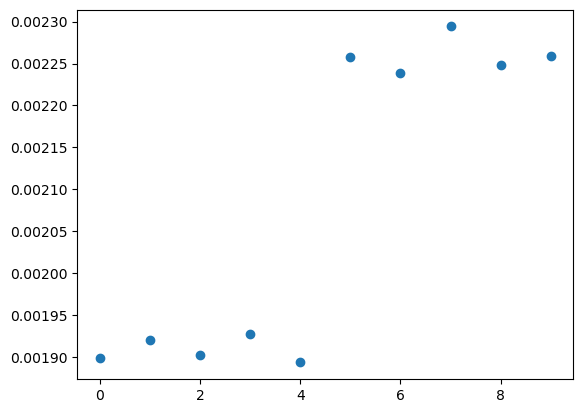

In [44]:
plt.scatter(range(len(cross_final_model_loss_lst)), cross_final_model_loss_lst)

In [45]:
def plot_final_model_losses(final_model_test_loss_lst, my_title="Final Model Loss On Test Set"):
    colors = ['red', 'blue', 'green', 'orange']  # Add more colors if necessary
    trial_colors = [colors[i // 5] for i in range(20)]  # Assign colors based on index

    plt.figure(figsize=(10, 5))
    plt.bar(range(len(final_model_test_loss_lst)), final_model_test_loss_lst, color=trial_colors)
    plt.title(my_title)
    plt.show()

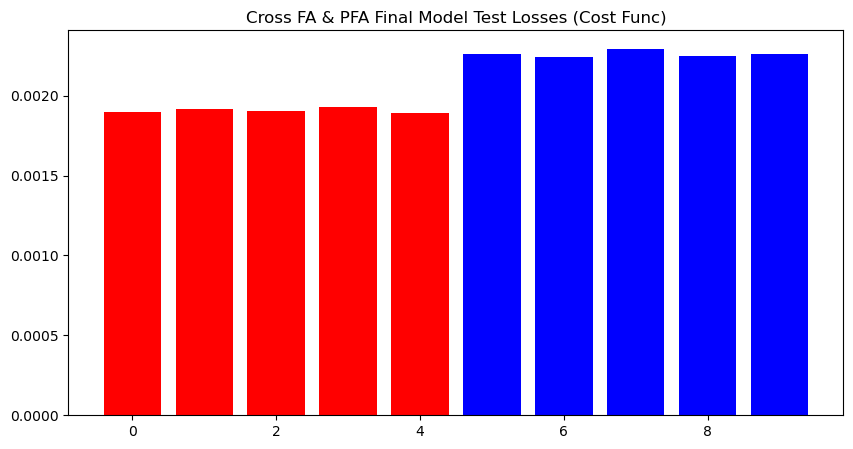

In [46]:
plot_final_model_losses(cross_final_model_loss_lst, my_title="Cross FA & PFA Final Model Test Losses (Cost Func)")

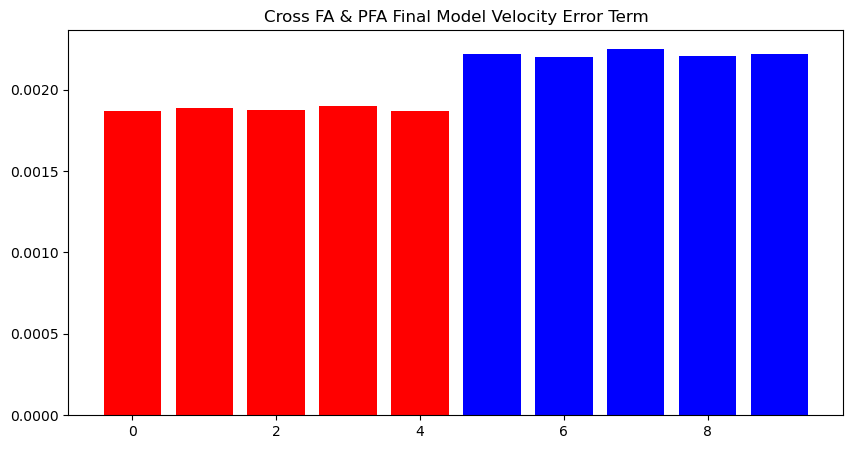

In [48]:
plot_final_model_losses(cross_final_model_vel_error_lst, my_title="Cross FA & PFA Final Model Velocity Error Term")

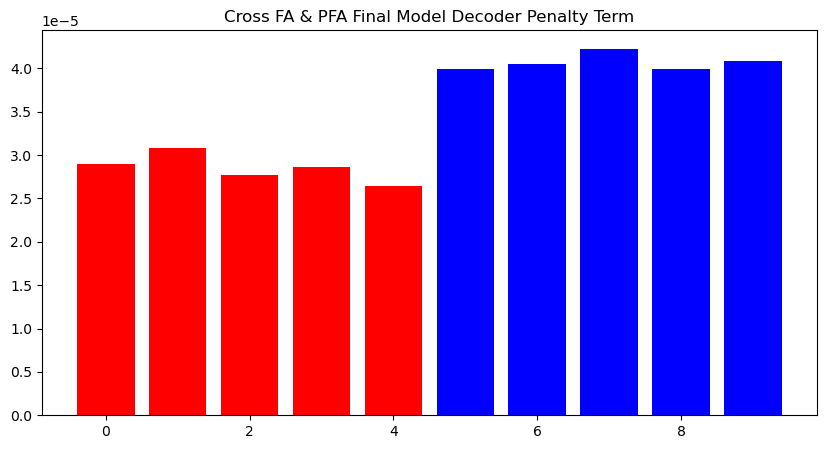

In [49]:
plot_final_model_losses(cross_final_model_dec_error_lst, my_title="Cross FA & PFA Final Model Decoder Penalty Term")

## INTRA-SUBJECT

In [59]:
SCENARIO = "INTRA"
intra_final_model_loss_dict = dict()
intra_final_model_vel_error_dict = dict()
intra_final_model_dec_error_dict = dict()

for fold_idx in range(NUM_KFOLDS):
    print(f"Fold {fold_idx+1}/{NUM_KFOLDS}")
    # Initialize clients for training
    full_client_lst = [Client(i, copy.deepcopy(D_0), OPT_METHOD, cond0_training_and_labels_lst[i], DATA_STREAM, 
                            scenario=SCENARIO, local_round_threshold=LOCAL_ROUND_THRESHOLD, current_fold=fold_idx, global_method=GLOBAL_METHOD, max_iter=MAX_ITER, 
                            num_steps=NUM_STEPS, use_zvel=USE_HITBOUNDS, test_split_type=TEST_SPLIT_TYPE) for i in range(NUM_USERS)]

    for cli in full_client_lst:
        for model_idx, model in enumerate(all_models_lst[:len(all_models_lst)//2]):
            model_name_idx = model_idx // NUM_KFOLDS
            fold_idx = model_idx % NUM_KFOLDS
            model_key_str = all_models_keys_lst[model_name_idx]+f"_Fold{str(fold_idx)}"
            
            test_loss, vel_error, dec_error = cli.test_metrics(model, which="global", return_cost_func_comps=True)
            intra_final_model_loss_dict[model_key_str] = test_loss
            intra_final_model_vel_error_dict[model_key_str] = vel_error
            intra_final_model_dec_error_dict[model_key_str] = dec_error

Fold 1/5
Created 5 folds:
Fold 0: 2 updates: [9, 10]
Fold 1: 1 updates: [11]
Fold 2: 2 updates: [12, 13]
Fold 3: 1 updates: [14]
Fold 4: 2 updates: [15, 16]
Fold 2/5
Created 5 folds:
Fold 0: 2 updates: [9, 10]
Fold 1: 1 updates: [11]
Fold 2: 2 updates: [12, 13]
Fold 3: 1 updates: [14]
Fold 4: 2 updates: [15, 16]
Fold 3/5
Created 5 folds:
Fold 0: 2 updates: [9, 10]
Fold 1: 1 updates: [11]
Fold 2: 2 updates: [12, 13]
Fold 3: 1 updates: [14]
Fold 4: 2 updates: [15, 16]
Fold 4/5
Created 5 folds:
Fold 0: 2 updates: [9, 10]
Fold 1: 1 updates: [11]
Fold 2: 2 updates: [12, 13]
Fold 3: 1 updates: [14]
Fold 4: 2 updates: [15, 16]
Fold 5/5
Created 5 folds:
Fold 0: 2 updates: [9, 10]
Fold 1: 1 updates: [11]
Fold 2: 2 updates: [12, 13]
Fold 3: 1 updates: [14]
Fold 4: 2 updates: [15, 16]


In [60]:
intra_final_model_loss_lst = list(intra_final_model_loss_dict.values())
intra_final_model_vel_error_lst = list(intra_final_model_vel_error_dict.values())
intra_final_model_dec_error_lst = list(intra_final_model_dec_error_dict.values())

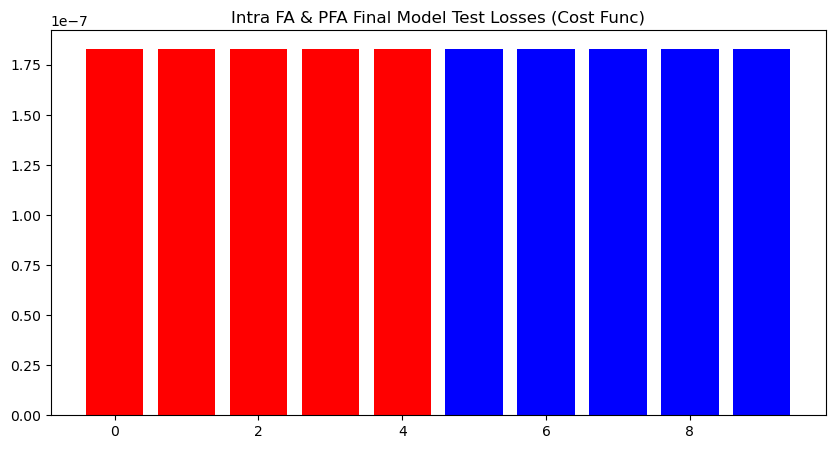

In [61]:
plot_final_model_losses(intra_final_model_loss_lst, my_title="Intra FA & PFA Final Model Test Losses (Cost Func)")

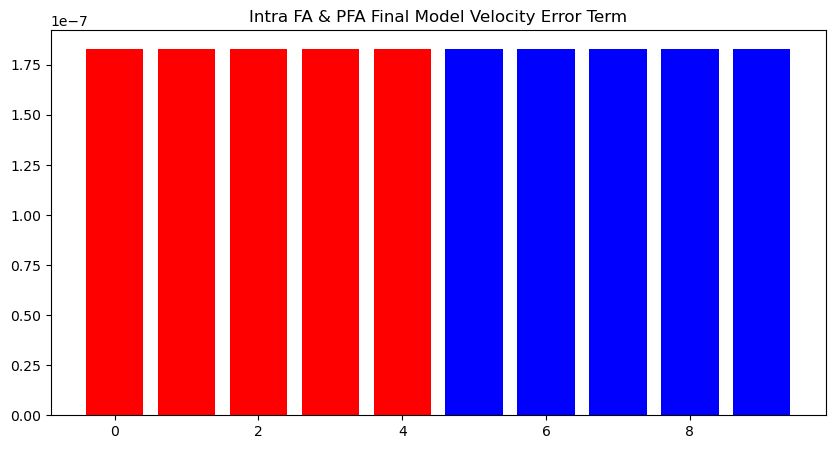

In [62]:
plot_final_model_losses(intra_final_model_vel_error_lst, my_title="Intra FA & PFA Final Model Velocity Error Term")

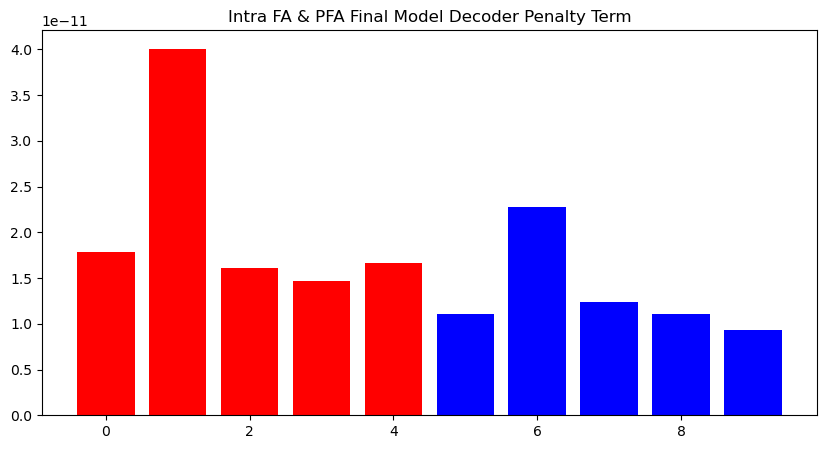

In [63]:
plot_final_model_losses(intra_final_model_dec_error_lst, my_title="Intra FA & PFA Final Model Decoder Penalty Term")